In [10]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
import peakutils.peak
from closest import closest

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def determine_dimming_duration(light_curve_df,
                               earliest_allowed_time=None, smooth_points=0, 
                               plot_path_filename=None, verbose=False):
    """Find the duration of dimming in a light curve, if any.
    Assumes light curve is normalized such that pre-flare = 0%.

    Inputs:
        light_curve_df [pd DataFrame]:    A pandas DataFrame with a DatetimeIndex and a column for irradiance.
        
    Optional Inputs:
        earliest_allowed_time [metatime]: The function won't return a duration if the only 0 crossings are earlier than this.
                                          Default is None, meaning the beginning of the light_curve_df.
        smooth_points [integer]:          Used to apply a rolling mean with the number of points (indices) specified.
                                          Default is 0, meaning no smoothing will be performed.
        plot_path_filename [str]:         Set to a path and filename in order to save the summary plot to disk.
                                          Default is None, meaning the plot will not be saved to disk.
        verbose [bool]:                   Set to log the processing messages to disk and console. Default is False.

    Outputs:
        duration_seconds [integer]: The duration of dimming in seconds. 
                                                 
    Optional Outputs:
        None

    Example:
        duration_seconds = determine_dimming_duration(light_curve_df,
                                                      plot_path_filename='./bla.png',
                                                      verbose=True)
    """
    return 1

In [11]:
# prototype only: set up example inputs
%matplotlib inline
plt.style.use('jpm-transparent-light')
earliest_allowed_time = pd.Timestamp('2012-04-15 17:52:20.0')
plot_path_filename = './bla.png'
verbose = True

light_curve_df = pd.read_hdf('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Corrected Dimming Light Curve.hdf5', 
                             'light_curve_corrected_df')
light_curve_df.head()

,irradiance
2012-04-15 17:43:20,NaN
2012-04-15 17:44:19,0.536402
2012-04-15 17:45:18,0.547532
2012-04-15 17:46:17,0.501033
2012-04-15 17:47:16,1.337536


In [12]:
# If no earliest_allowed_time set, then set it to beginning of light_curve_df
if not earliest_allowed_time:
    earliest_allowed_time = pd.Timestamp(light_curve_df.index.values[0])

In [3]:
# Prepare the logger for verbose
if verbose:
    # TODO: Update the path
    logger = JpmLogger(filename='determine_dimming_duration_log', path='/Users/jmason86/Desktop/')

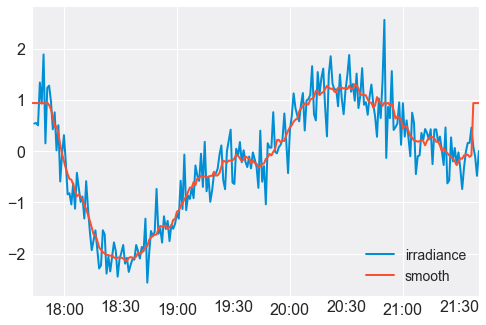

In [4]:
# Optionally smooth the light curve with a rolling mean
if smooth_points:
    light_curve_df['smooth'] = light_curve_df.rolling(smooth_points, center=True).mean()
else:
    light_curve_df['smooth'] = light_curve_df['irradiance']

first_non_nan = light_curve_df['smooth'].first_valid_index()
nan_indices = np.isnan(light_curve_df['smooth'])
light_curve_df['smooth'][nan_indices] = light_curve_df['smooth'][first_non_nan]
light_curve_df.plot();

In [5]:
# Find the indices where the light curve is closest to 0
zero_crossing_indices = np.where(np.diff(np.signbit(light_curve_df['smooth'])))[0]
zero_crossing_times = light_curve_df.index[zero_crossing_indices]

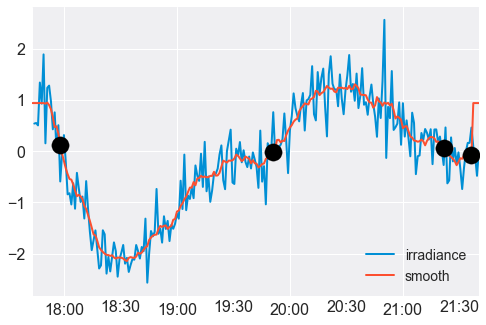

In [6]:
# prototype only: just taking a look at how it's doing
light_curve_df.plot()
plt.scatter(zero_crossing_times, light_curve_df['smooth'][zero_crossing_indices], 
            c='black', s=300, zorder=3);

In [7]:
# Discard any indices prior to the user-provided earliest_allowed_time, else return null
zero_crossing_indices = zero_crossing_indices[zero_crossing_times > earliest_allowed_time]
if zero_crossing_indices.size == 0:
    logger.warning('No zero crossings detected before earliest allowed time of %s' % earliest_allowed_time)
    #return None

In [8]:
# Figure out which way the light curve is sloping
light_curve_df['diff'] = light_curve_df['smooth'].diff()

In [9]:
# Find the first negative slope zero crossing time
first_neg_zero_crossing_index = np.where(light_curve_df['diff'][zero_crossing_indices + 1] < 0)[0][0]
first_neg_zero_crossing_time = light_curve_df.index[zero_crossing_indices[first_neg_zero_crossing_index]]

In [10]:
# Find the first postiive slope zero crossing
first_pos_zero_crossing_index = np.where(light_curve_df['diff'][zero_crossing_indices + 1] > 0)[0][0]
first_pos_zero_crossing_time = light_curve_df.index[zero_crossing_indices[first_pos_zero_crossing_index]]

In [11]:
# If the first negative slope zero crossing isn't earlier than the positive one, return null
if first_neg_zero_crossing_time > first_pos_zero_crossing_time:
    logger.warning('Dimming light curve may be misaligned in window. Negative slope 0-crossing detected after positive one.')
    #return None

2017-12-20 11:30:35,228 [INFO ] [<module>] Summary plot saved to ./bla.png


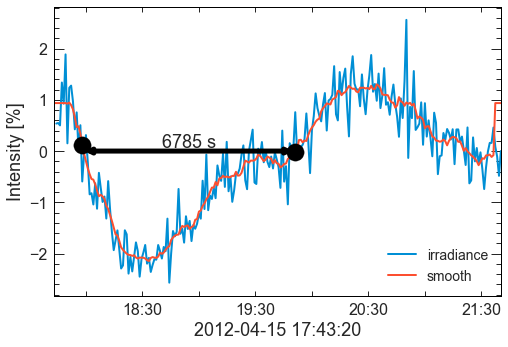

In [31]:
# Return the time difference in seconds between the selected zero crossings
duration_seconds = int((first_pos_zero_crossing_time - first_neg_zero_crossing_time).total_seconds())

if plot_path_filename:
    plt.style.use('jpm-transparent-light')
    from matplotlib import dates
    
    #light_curve_df = light_curve_df.drop('diff', 1)
    ax = light_curve_df.plot()
    plt.scatter([zero_crossing_times[first_neg_zero_crossing_index], zero_crossing_times[first_pos_zero_crossing_index]],
                [light_curve_df['smooth'][zero_crossing_indices[first_neg_zero_crossing_index]], light_curve_df['smooth'][zero_crossing_indices[first_pos_zero_crossing_index]]], 
                c='black', s=300, zorder=3);
    start_date = light_curve_df.index.values[0]
    start_date_string = pd.to_datetime(str(start_date))
    plt.xlabel(start_date_string.strftime('%Y-%m-%d %H:%M:%S'))
    plt.ylabel('Irradiance [%]')
    fmtr = dates.DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(fmtr)
    ax.xaxis.set_major_locator(dates.HourLocator())
    
    plt.annotate('', xy=(first_neg_zero_crossing_time, 0), xycoords='data',
                 xytext=(first_pos_zero_crossing_time, 0), textcoords='data',
                 arrowprops=dict(facecolor='black', linewidth=5, arrowstyle='<->'))
    mid_time = first_neg_zero_crossing_time + (first_pos_zero_crossing_time - first_neg_zero_crossing_time) / 2
    plt.annotate(str(duration_seconds) + ' s', xy=(mid_time, 0), xycoords='data', ha='center', va='bottom', size=18)
    plt.savefig(plot_path_filename)
    if verbose:
        logger.info("Summary plot saved to %s" % plot_path_filename)

# return duration_seconds